In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from quantipy.assets import Currency, Equity
from quantipy.trading import Broker, TripleMovingAverage
from quantipy.backtest import Backtester


# backtest period
BACKTEST_START = '2016-01-01'
LIVE_START = '2021-01-01'

# trading universe
CAPITAL = 10_000
eur = Currency('EUR')
asml = Equity('ASML', 'ASML')
lvmh = Equity('LVMH', 'MC.PA')
spy = Equity('SPY', 'SPY')
MKT = [spy]

# strategy
STRATEGY = TripleMovingAverage(MKT, {})

# strategy parameters
# PARAMS = {
#     'history1': [3, 4, 5, 6], 
#     'history2': [7, 9, 10, 12, 15],
#     'history3': [21, 24, 27, 30]
# }

PARAMS = {
    'history1': [4], 
    'history2': [15],
    'history3': [21]
}

TARGET = 'sharpe'

In [2]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=BACKTEST_START, end=LIVE_START,
                                 interval='1d')
    data[asset.symbol] = ticker_data

broker = Broker(data=data, initial_capital=CAPITAL, currency=eur)
backtester = Backtester(data)

opt_results = backtester.optimize(
    STRATEGY, broker, PARAMS, target=TARGET, save_logs=False
)

opt_results['best_params']

{'history1': 4, 'history2': 15, 'history3': 21}
Score: 0.7898048820912089


/home/luissimaoaf/self/dev/quantipy/quantipy/backtest.py:116: RuntimeWarning: divide by zero encountered in log
  results['log_returns'] = np.log(results['returns'])
/home/luissimaoaf/self/dev/quantipy/quantipy/backtest.py:116: RuntimeWarning: invalid value encountered in log
  results['log_returns'] = np.log(results['returns'])


{'history1': 4, 'history2': 15, 'history3': 21}

/tmp/ipykernel_19716/1976108910.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nprice = np.array(data['SPY']['Close'])*10000/data['SPY']['Close'][0]


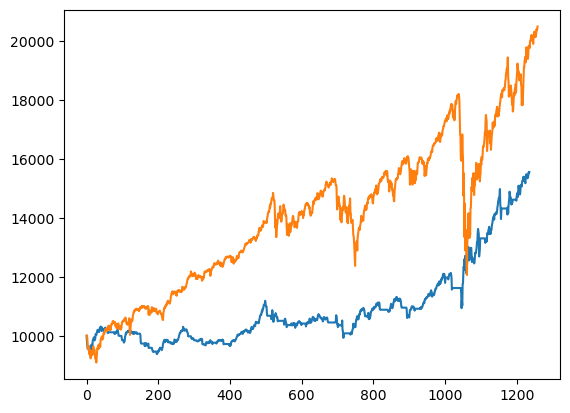

In [3]:
plt.plot(opt_results['equity'])
nprice = np.array(data['SPY']['Close'])*10000/data['SPY']['Close'][0]
plt.plot(nprice)

In [4]:
# getting data
data = {}
for asset in MKT:
    ticker = yf.ticker.Ticker(asset.symbol)
    ticker_data = ticker.history(start=BACKTEST_START, interval='1d')
    data[asset.symbol] = ticker_data

STRATEGY.params = opt_results['best_params']
capital = opt_results['final_equity']
broker = Broker(data=data, initial_capital=capital, currency=eur)
live_backtester = Backtester(data)

live_backtester.run(STRATEGY, broker, save_logs=True)
results = live_backtester.process_results(rolling=252)

/home/luissimaoaf/self/dev/quantipy/quantipy/backtest.py:116: RuntimeWarning: divide by zero encountered in log
  results['log_returns'] = np.log(results['returns'])
/home/luissimaoaf/self/dev/quantipy/quantipy/backtest.py:116: RuntimeWarning: invalid value encountered in log
  results['log_returns'] = np.log(results['returns'])


/tmp/ipykernel_19716/1665616506.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(np.array(data['SPY']['Close'][15:])/data['SPY']['Close'][15])


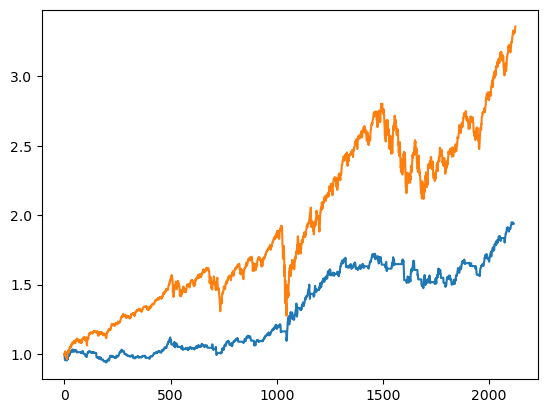

In [5]:
plt.figure()
plt.plot(results['equity']/capital)
plt.plot(np.array(data['SPY']['Close'][15:])/data['SPY']['Close'][15])

0.6817145544040865


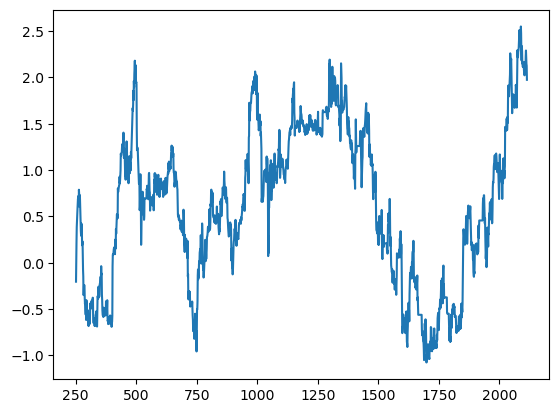

In [6]:
plt.plot(results['rolling_sharpe'])
print(results['sharpe'])

In [7]:
backtester.show_results(results)

Backtest Results
----------------------------------------
Metric           Strategy      Benchmark
----------------------------------------
Total Return:      93.81%
Volatility:        0.1072
Sharpe Ratio:      0.6817
Avg loss (bar):    -0.56%
----------------------------------------
Max Drawdown:     -14.39%
Avg Drawdown:      -4.23%
Avg DD Bars:           28
Longest DD:           548
----------------------------------------
Trades:                75
Time in Market:    71.02%
